## Convolutional Neural Network (CNN)

In this notebook, we will attempt to train a simple CNN model on our IMDB movie reviews dataset and evaluate its performance.

### 1. Loading the Dataset

Dataset has been split into train-test beforehand.

In [ ]:
import pandas as pd

# load train dataset
train_df = pd.read_csv('data/train_set.csv')
# load test dataset
test_df = pd.read_csv('data/test_set.csv')

X_train = train_df['text']
y_train = train_df['sentiment']

X_test = test_df['text']
y_test = test_df['sentiment']

### 2. Text Preprocessing: Tokenization and Padding of Reviews

As we will need to tokenize our reviews (since the model isn't able to interpret raw text), we will need to pad the reviews after tokenising based on maximum length. We shall take the average lengths of the reviews in our dataset to determine what value to use as our maximum length.

In [ ]:
# get the mean and max length of the text in the train set
mean_length = X_train.str.split().str.len().mean()
max_length = X_train.str.split().str.len().max()
print(f'Mean length of text: {mean_length}')
print(f'Max length of text: {max_length}')
# get the mean and max length of the text in the test set
mean_length = X_test.str.split().str.len().mean()
max_length = X_test.str.split().str.len().max()
print(f'Mean length of text (test set): {mean_length}')
print(f'Max length of text (test set): {max_length}')

Mean length of text: 122.2985
Max length of text: 1451
Mean length of text (test set): 123.666
Max length of text (test set): 1129


Average lengths hover around 120+, we shall take the upper bound of 200 as our maximum length to cover most reviews (albeit longer review texts).

We next load the relevant libraries to tokenize our movie review text.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedKFold

Tokenizing and padding to ensure all reviews are of uniform length.

In [ ]:
# set up preprocessing parameters
vocab_size = 10000 # vocab size that covers 10k most frequent words in our dataset
max_length = 200 # mean length is about 120+ words so we set max to 200

# initialise and fit tokenizer on trainig data
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>') # adding OOV to hadnle words not in vocab
tokenizer.fit_on_texts(X_train)

# convert move review text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# pad sequences to ensure all reviews are of uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

### 3. Building CNN Architecture

In this block, we will define our CNN architecture. We will be using an embedding layer to convert word indices to dense vectors and two covolutional layers, as well as a dense layer for our classification output.

In [ ]:
# define CNN model using a function
def build_cnn_model(vocab_size, embedding_dim, max_length, filters1=64, filters2=128, dense_units=64):
    """Builds the CNN model with configurable parameters."""
    print(f"  Building CNN with embedding_dim={embedding_dim}, filters1={filters1}")
    model = models.Sequential([
        layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        layers.Conv1D(filters=filters1, kernel_size=5, activation='relu'), # Use filters1
        layers.MaxPooling1D(pool_size=4),
        layers.Conv1D(filters=filters2, kernel_size=5, activation='relu'), # Keep filters2 fixed or add as param
        layers.GlobalMaxPool1D(),
        layers.Dense(dense_units, activation='relu'), # Keep dense_units fixed or add as param
        layers.Dense(1, activation='sigmoid')
    ])
    return model

### 4. Cross-Validation and Basic Hyperparameter Tuning

Before model training, we will attempt to do 5-Fold Cross Validation with our CNN model and set some hyperparameters for basic hyperparameter tuning.

In [ ]:
import itertools # for easy looping through combinations

# set up CV configuration
N_SPLITS = 5
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# hyperparameters for CNN tuning
embedding_dims = [50, 100]
filter1_couns = [32, 64, 128]
learning_rates = [0.001, 0.0005]

# fixed parameters during CV
EPOCHS_CV_CNN = 10
BATCH_SIZE_CNN = 32 # standard batch size
FIXED_VOCAB_SIZE = vocab_size
FIXED_MAX_LENGTH = max_length

We carry out the 5-Fold CV here and also introduce early stopping to prevent overfitting.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

cnn_cv_results = []
cnn_misclassified_data = []

best_cnn_score = -1
best_cnn_params = {}

param_combinations = list(itertools.product(embedding_dims, filter1_couns, learning_rates))

for combo_idx, (embed_dim, f1_count, lr) in enumerate(param_combinations):
    print(f"\n--- Testing Combo {combo_idx+1}/{len(param_combinations)}: embed={embed_dim}, filters1={f1_count}, lr={lr} ---")
    # Store fold accuracies for calculating mean/std for this combo
    fold_accuracies = []

    # --- Inner loop for Cross-Validation Folds ---
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_pad, y_train)):
        print(f"  Fold {fold + 1}/{N_SPLITS}...")

        # 1. Split data (already numerical)
        X_train_fold, y_train_fold = X_train_pad[train_idx], y_train[train_idx].values
        X_val_fold, y_val_fold = X_train_pad[val_idx], y_train[val_idx].values

        # 2. Rebuild the CNN model with current hyperparameters
        cnn_model_fold = build_cnn_model(
            vocab_size=FIXED_VOCAB_SIZE,
            embedding_dim=embed_dim,
            max_length=FIXED_MAX_LENGTH,
            filters1=f1_count
        )

        # 3. Compile the model
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        cnn_model_fold.compile(optimizer=optimizer,
                               loss='binary_crossentropy',
                               metrics=['accuracy'])

        # 4. Train the model with Early Stopping
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True, verbose=0)
        history = cnn_model_fold.fit(
            X_train_fold, y_train_fold,
            epochs=EPOCHS_CV_CNN,
            batch_size=BATCH_SIZE_CNN,
            validation_data=(X_val_fold, y_val_fold),
            callbacks=[early_stopping],
            verbose=1 # Keep training output minimal during CV
        )

        # 5. Evaluate on the validation set for this fold
        # Evaluate uses the potentially restored best weights if EarlyStopping triggered
        loss, accuracy = cnn_model_fold.evaluate(X_val_fold, y_val_fold, batch_size=BATCH_SIZE_CNN, verbose=0)
        fold_accuracies.append(accuracy)

        # --- 6. Predict & Track First 5 Misclassifications ---
        y_pred_proba_fold = cnn_model_fold.predict(X_val_fold, batch_size=BATCH_SIZE_CNN)
        # Convert probabilities to 0/1 labels
        y_pred_fold = (y_pred_proba_fold > 0.5).astype(int).flatten() # Flatten if shape is (N, 1)

        # Find indices where prediction != true label (relative to X_val_fold)
        misclassified_indices_in_fold = np.where(y_pred_fold != y_val_fold)[0]

        # Store details for the first 5 misclassified samples in this fold
        misclassified_count_this_fold = 0
        for local_idx in misclassified_indices_in_fold:
            if misclassified_count_this_fold >= 5:
                break # Stop after collecting 5 samples for this fold

            original_train_idx = val_idx[local_idx] # Map back to original X_train index
            original_text = X_train[original_train_idx]

            misclassified_info = {
                'original_train_index': original_train_idx,
                'fold': fold + 1,
                'embed_dim': embed_dim, # Store params used
                'filters1': f1_count,
                'lr': lr,
                'text': original_text, # Store the actual text
                'true_label': y_val_fold[local_idx],
                'predicted_label': y_pred_fold[local_idx],
                'predicted_probability': y_pred_proba_fold[local_idx][0]
            }
            cnn_misclassified_data.append(misclassified_info)
            misclassified_count_this_fold += 1
        # --- End Misclassification Tracking ---

        # --- End Fold Loop ---

    # Calculate and store mean accuracy for this hyperparameter combo
    mean_combo_accuracy = np.mean(fold_accuracies)
    std_combo_accuracy = np.std(fold_accuracies)
    # Print concise summary for the combo
    print(f"  --- Mean Validation Accuracy: {mean_combo_accuracy:.4f} ± {std_combo_accuracy:.4f} ---")

    # Store the mean result for this combination
    cnn_cv_results.append({
        'embed_dim': embed_dim, 'filters1': f1_count, 'lr': lr,
        'mean_val_accuracy': mean_combo_accuracy,
        'std_val_accuracy': std_combo_accuracy
    })

    # Track the best combination found so far (silently)
    if mean_combo_accuracy > best_cnn_score:
        best_cnn_score = mean_combo_accuracy
        best_cnn_params = {'embed_dim': embed_dim, 'filters1': f1_count, 'lr': lr}


--- Testing Combo 1/12: embed=50, filters1=32, lr=0.001 ---
  Fold 1/5...
  Building CNN with embedding_dim=50, filters1=32
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7396 - loss: 0.4741 - val_accuracy: 0.8695 - val_loss: 0.3068
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9249 - loss: 0.1958 - val_accuracy: 0.8845 - val_loss: 0.2968
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9699 - loss: 0.0921 - val_accuracy: 0.8652 - val_loss: 0.4212
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9891 - loss: 0.0371 - val_accuracy: 0.8714 - val_loss: 0.4887
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Fold 2/5...
  Building CNN with embedding_dim=50, filters1=32
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7415 - loss: 0.4732 - val_accuracy: 0.8752 - val_loss: 0.2925
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9269 - loss: 0.1959 - val_accuracy: 0.8839 - val_loss: 0.2835
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9700 - loss: 0.0913 - val_accuracy: 0.8602 - val_loss: 0.4198
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9897 - loss: 0.0357 - val_accuracy: 0.8708 - val_loss: 0.4938
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Fold 3/5...
  Building CNN with embedding_dim=50, filters1=32
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7365 - loss: 0.4761 - val_accuracy: 0.8784 - val_loss: 0.2826
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9279 - loss: 0.1912 - val_accuracy: 0.8809 - val_loss: 0.2980
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9717 - loss: 0.0857 - val_accuracy: 0.8661 - val_loss: 0.3930
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9909 - loss: 0.0328 - val_accuracy: 0.8660 - val_loss: 0.5241
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Fold 4/5...
  Building CNN with embedding_dim=50, filters1=32
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7399 - loss: 0.4701 - val_accuracy: 0.8781 - val_loss: 0.2896
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9268 - loss: 0.1941 - val_accuracy: 0.8756 - val_loss: 0.3129
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9726 - loss: 0.0837 - val_accuracy: 0.8681 - val_loss: 0.4115
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Fold 5/5...
  Building CNN with embedding_dim=50, filters1=32
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7186 - loss: 0.4919 - val_accuracy: 0.8774 - val_loss: 0.2879
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9305 - loss: 0.1891 - val_accuracy: 0.8700 - val_loss: 0.3159
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9732 - loss: 0.0862 - val_accuracy: 0.8666 - val_loss: 0.4167
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  --- Mean Validation Accuracy: 0.8810 ± 0.0029 ---

--- Testing Combo 2/12: embed=50, filters1=32, lr=0.0005 ---
  Fold 1/5...
  Building CNN with embedding_dim=50, filters1=32
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6959 - loss: 0.5172 - val_accuracy: 0.8696 - val_loss: 0.3140
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9221 - loss: 0.2047 - val_accuracy: 0.8764 - val_loss: 0.3007
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9640 - loss: 0.1083 - val_accuracy: 0.8727 - val_loss: 0.3496
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9882 - loss: 0.0447 - val_accuracy: 0.8717 - val_loss: 0.4218
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Fold 2/5...
  Building CNN with embedding_dim=50, filters1=32
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7187 - loss: 0.5066 - val_accuracy: 0.8820 - val_loss: 0.2860
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9203 - loss: 0.2055 - val_accuracy: 0.8790 - val_loss: 0.2993
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9644 - loss: 0.1109 - val_accuracy: 0.8636 - val_loss: 0.3868
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Fold 3/5...
  Building CNN with embedding_dim=50, filters1=32
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6947 - loss: 0.5233 - val_accuracy: 0.8714 - val_loss: 0.2963
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9241 - loss: 0.2050 - val_accuracy: 0.8773 - val_loss: 0.2904
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9602 - loss: 0.1182 - val_accuracy: 0.8709 - val_loss: 0.3431
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9870 - loss: 0.0508 - val_accuracy: 0.8696 - val_loss: 0.4137
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Fold 4/5...
  Building CNN with embedding_dim=50, filters1=32
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6955 - loss: 0.5182 - val_accuracy: 0.8735 - val_loss: 0.2979
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9227 - loss: 0.2054 - val_accuracy: 0.8765 - val_loss: 0.2967
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9634 - loss: 0.1131 - val_accuracy: 0.8708 - val_loss: 0.3390
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9886 - loss: 0.0470 - val_accuracy: 0.8665 - val_loss: 0.4415
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  Fold 5/5...
  Building CNN with embedding_dim=50, filters1=32
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7168 - loss: 0.4995 - val_accuracy: 0.8719 - val_loss: 0.3025
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9209 - loss: 0.2054 - val_accuracy: 0.8781 - val_loss: 0.2999
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9618 - loss: 0.1184 - val_accuracy: 0.8685 - val_loss: 0.3614
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9882 - loss: 0.0474 - val_accuracy: 0.8649 - val_loss: 0.4515
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
  --- Mean Validation Accuracy: 0.8781 ± 0.0021 ---

--- Testing Combo 3/12: embed=50, filters1=64, lr=0.001 ---
  Fold 1/5...
  Building CNN with embedding_dim=50, filters1=64
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7353 - loss: 0.4783 - val_accuracy: 0.8809 - val_loss: 0.2918
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9258 - loss: 0.1911 - val_accuracy: 0.8819 - val_loss: 0.2984
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9709 - loss: 0.0927 - val_accuracy: 0.8767 - val_loss: 0.3902
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9902 - loss: 0.0359 - val_accuracy: 0.8625 - val_loss: 0.5544
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Fold 2/5...
  Building CNN with embedding_dim=50, filters1=64
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7391 - loss: 0.4751 - val_accuracy: 0.8749 - val_loss: 0.2977
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9233 - loss: 0.1913 - val_accuracy: 0.8824 - val_loss: 0.2954
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9707 - loss: 0.0926 - val_accuracy: 0.8801 - val_loss: 0.3565
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9903 - loss: 0.0364 - val_accuracy: 0.8696 - val_loss: 0.4821
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  Fold 3/5...
  Building CNN with embedding_dim=50, filters1=64
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7030 - loss: 0.5106 - val_accuracy: 0.8766 - val_loss: 0.2877
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9251 - loss: 0.1979 - val_accuracy: 0.8741 - val_loss: 0.3156
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9674 - loss: 0.0998 - val_accuracy: 0.8767 - val_loss: 0.3630
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9897 - loss: 0.0390 - val_accuracy: 0.8648 - val_loss: 0.4482
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9942 - loss: 0.0217 - val_accuracy: 0.8630 - val_loss: 0.6842
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  Fold 4/5...
  Building CNN with embedding_dim=50, filters1=64
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7240 - loss: 0.4903 - val_accuracy: 0.8660 - val_loss: 0.3179
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9260 - loss: 0.1870 - val_accuracy: 0.8741 - val_loss: 0.2963
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9691 - loss: 0.0938 - val_accuracy: 0.8702 - val_loss: 0.3340
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9880 - loss: 0.0442 - val_accuracy: 0.8654 - val_loss: 0.5019
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Fold 5/5...
  Building CNN with embedding_dim=50, filters1=64
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7394 - loss: 0.4749 - val_accuracy: 0.8735 - val_loss: 0.2985
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9251 - loss: 0.1976 - val_accuracy: 0.8755 - val_loss: 0.3011
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9680 - loss: 0.0972 - val_accuracy: 0.8709 - val_loss: 0.3539
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9868 - loss: 0.0453 - val_accuracy: 0.8644 - val_loss: 0.5319
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  --- Mean Validation Accuracy: 0.8781 ± 0.0034 ---

--- Testing Combo 4/12: embed=50, filters1=64, lr=0.0005 ---
  Fold 1/5...
  Building CNN with embedding_dim=50, filters1=64
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.6878 - loss: 0.5221 - val_accuracy: 0.8695 - val_loss: 0.3130
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9219 - loss: 0.2053 - val_accuracy: 0.8839 - val_loss: 0.2902
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9603 - loss: 0.1199 - val_accuracy: 0.8777 - val_loss: 0.3422
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9859 - loss: 0.0518 - val_accuracy: 0.8726 - val_loss: 0.4486
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Fold 2/5...
  Building CNN with embedding_dim=50, filters1=64
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7022 - loss: 0.5215 - val_accuracy: 0.8790 - val_loss: 0.2841
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9184 - loss: 0.2100 - val_accuracy: 0.8809 - val_loss: 0.2824
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9569 - loss: 0.1308 - val_accuracy: 0.8765 - val_loss: 0.3345
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9846 - loss: 0.0592 - val_accuracy: 0.8754 - val_loss: 0.4236
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  Fold 3/5...
  Building CNN with embedding_dim=50, filters1=64
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7006 - loss: 0.5140 - val_accuracy: 0.8679 - val_loss: 0.3003
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9175 - loss: 0.2140 - val_accuracy: 0.8744 - val_loss: 0.2963
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9605 - loss: 0.1194 - val_accuracy: 0.8774 - val_loss: 0.3291
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9847 - loss: 0.0570 - val_accuracy: 0.8645 - val_loss: 0.4523
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9949 - loss: 0.0229 - val_accuracy: 0.8600 - val_loss: 0.5152
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Fold 4/5...
  Building CNN with embedding_dim=50, filters1=64
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7008 - loss: 0.5160 - val_accuracy: 0.8810 - val_loss: 0.2911
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9221 - loss: 0.1995 - val_accuracy: 0.8780 - val_loss: 0.2925
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9582 - loss: 0.1202 - val_accuracy: 0.8730 - val_loss: 0.3433
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  Fold 5/5...
  Building CNN with embedding_dim=50, filters1=64
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.7019 - loss: 0.5193 - val_accuracy: 0.8720 - val_loss: 0.3047
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9218 - loss: 0.2061 - val_accuracy: 0.8796 - val_loss: 0.2870
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9633 - loss: 0.1114 - val_accuracy: 0.8646 - val_loss: 0.3806
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9897 - loss: 0.0422 - val_accuracy: 0.8644 - val_loss: 0.4910
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  --- Mean Validation Accuracy: 0.8806 ± 0.0021 ---

--- Testing Combo 5/12: embed=50, filters1=128, lr=0.001 ---
  Fold 1/5...
  Building CNN with embedding_dim=50, filters1=128
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.7568 - loss: 0.4569 - val_accuracy: 0.8770 - val_loss: 0.2944
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9232 - loss: 0.1979 - val_accuracy: 0.8665 - val_loss: 0.3293
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9637 - loss: 0.1086 - val_accuracy: 0.8765 - val_loss: 0.3475
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
  Fold 2/5...
  Building CNN with embedding_dim=50, filters1=128
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.7236 - loss: 0.4821 - val_accuracy: 0.8756 - val_loss: 0.2933
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9205 - loss: 0.2058 - val_accuracy: 0.8820 - val_loss: 0.2889
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9641 - loss: 0.1083 - val_accuracy: 0.8725 - val_loss: 0.3398
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9844 - loss: 0.0515 - val_accuracy: 0.8773 - val_loss: 0.4638
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
  Fold 3/5...
  Building CNN with embedding_dim=50, filters1=128
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.7483 - loss: 0.4668 - val_accuracy: 0.8780 - val_loss: 0.2868
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9245 - loss: 0.1952 - val_accuracy: 0.8771 - val_loss: 0.2963
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9662 - loss: 0.1003 - val_accuracy: 0.8687 - val_loss: 0.3591
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
  Fold 4/5...
  Building CNN with embedding_dim=50, filters1=128
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.7443 - loss: 0.4663 - val_accuracy: 0.8809 - val_loss: 0.2910
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9290 - loss: 0.1912 - val_accuracy: 0.8751 - val_loss: 0.3047
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9680 - loss: 0.0978 - val_accuracy: 0.8687 - val_loss: 0.3944
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
  Fold 5/5...
  Building CNN with embedding_dim=50, filters1=128
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.7443 - loss: 0.4734 - val_accuracy: 0.8817 - val_loss: 0.2844
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9250 - loss: 0.1952 - val_accuracy: 0.8740 - val_loss: 0.3118
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9642 - loss: 0.1065 - val_accuracy: 0.8754 - val_loss: 0.3640
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
  --- Mean Validation Accuracy: 0.8799 ± 0.0020 ---

--- Testing Combo 6/12: embed=50, filters1=128, lr=0.0005 ---
  Fold 1/5...
  Building CNN with embedding_dim=50, filters1=128
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.6961 - loss: 0.5143 - val_accuracy: 0.8761 - val_loss: 0.2995
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9176 - loss: 0.2122 - val_accuracy: 0.8786 - val_loss: 0.2947
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9565 - loss: 0.1277 - val_accuracy: 0.8758 - val_loss: 0.3519
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9825 - loss: 0.0586 - val_accuracy: 0.8712 - val_loss: 0.4188
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
  Fold 2/5...
  Building CNN with embedding_dim=50, filters1=128
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.7167 - loss: 0.5043 - val_accuracy: 0.8748 - val_loss: 0.2862
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.9180 - loss: 0.2126 - val_accuracy: 0.8832 - val_loss: 0.2808
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9592 - loss: 0.1230 - val_accuracy: 0.8680 - val_loss: 0.3500
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9837 - loss: 0.0572 - val_accuracy: 0.8709 - val_loss: 0.4098
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
  Fold 3/5...
  Building CNN with embedding_dim=50, filters1=128
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.6981 - loss: 0.5170 - val_accuracy: 0.8733 - val_loss: 0.2957
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9213 - loss: 0.2075 - val_accuracy: 0.8755 - val_loss: 0.2928
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9566 - loss: 0.1274 - val_accuracy: 0.8720 - val_loss: 0.3403
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9842 - loss: 0.0598 - val_accuracy: 0.8571 - val_loss: 0.4473
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
  Fold 4/5...
  Building CNN with embedding_dim=50, filters1=128
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.7131 - loss: 0.5031 - val_accuracy: 0.8752 - val_loss: 0.2912
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9205 - loss: 0.2059 - val_accuracy: 0.8774 - val_loss: 0.2906
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9611 - loss: 0.1187 - val_accuracy: 0.8698 - val_loss: 0.3378
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9819 - loss: 0.0638 - val_accuracy: 0.8648 - val_loss: 0.4455
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
  Fold 5/5...
  Building CNN with embedding_dim=50, filters1=128
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.7046 - loss: 0.5066 - val_accuracy: 0.8814 - val_loss: 0.2919
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9207 - loss: 0.2117 - val_accuracy: 0.8589 - val_loss: 0.3405
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9566 - loss: 0.1264 - val_accuracy: 0.8758 - val_loss: 0.3398
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
  --- Mean Validation Accuracy: 0.8792 ± 0.0028 ---

--- Testing Combo 7/12: embed=100, filters1=32, lr=0.001 ---
  Fold 1/5...
  Building CNN with embedding_dim=100, filters1=32
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.7392 - loss: 0.4715 - val_accuracy: 0.8708 - val_loss: 0.3085
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9334 - loss: 0.1777 - val_accuracy: 0.8760 - val_loss: 0.3132
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9790 - loss: 0.0684 - val_accuracy: 0.8731 - val_loss: 0.4056
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9935 - loss: 0.0226 - val_accuracy: 0.8629 - val_loss: 0.5409
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Fold 2/5...
  Building CNN with embedding_dim=100, filters1=32
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.7235 - loss: 0.4819 - val_accuracy: 0.8851 - val_loss: 0.2768
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9350 - loss: 0.1794 - val_accuracy: 0.8823 - val_loss: 0.2910
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9762 - loss: 0.0794 - val_accuracy: 0.8662 - val_loss: 0.3787
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Fold 3/5...
  Building CNN with embedding_dim=100, filters1=32
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.7410 - loss: 0.4649 - val_accuracy: 0.8804 - val_loss: 0.2812
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9323 - loss: 0.1758 - val_accuracy: 0.8736 - val_loss: 0.3093
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9768 - loss: 0.0721 - val_accuracy: 0.8752 - val_loss: 0.3841
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Fold 4/5...
  Building CNN with embedding_dim=100, filters1=32
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.7558 - loss: 0.4531 - val_accuracy: 0.8783 - val_loss: 0.2859
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9356 - loss: 0.1764 - val_accuracy: 0.8572 - val_loss: 0.3562
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9781 - loss: 0.0682 - val_accuracy: 0.8740 - val_loss: 0.4014
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  Fold 5/5...
  Building CNN with embedding_dim=100, filters1=32
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.7437 - loss: 0.4648 - val_accuracy: 0.8849 - val_loss: 0.2839
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9343 - loss: 0.1780 - val_accuracy: 0.8586 - val_loss: 0.3507
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9781 - loss: 0.0729 - val_accuracy: 0.8635 - val_loss: 0.4086
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  --- Mean Validation Accuracy: 0.8809 ± 0.0036 ---

--- Testing Combo 8/12: embed=100, filters1=32, lr=0.0005 ---
  Fold 1/5...
  Building CNN with embedding_dim=100, filters1=32
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.7250 - loss: 0.4927 - val_accuracy: 0.8644 - val_loss: 0.3170
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9255 - loss: 0.1993 - val_accuracy: 0.8775 - val_loss: 0.3098
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9698 - loss: 0.0978 - val_accuracy: 0.8776 - val_loss: 0.3667
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9927 - loss: 0.0302 - val_accuracy: 0.8684 - val_loss: 0.5330
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9980 - loss: 0.0084 - val_accuracy: 0.8709 - val_loss: 0.6396
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  Fold 2/5...
  Building CNN with embedding_dim=100, filters1=32
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.7200 - loss: 0.4976 - val_accuracy: 0.8834 - val_loss: 0.2811
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9277 - loss: 0.1925 - val_accuracy: 0.8801 - val_loss: 0.2998
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9729 - loss: 0.0917 - val_accuracy: 0.8785 - val_loss: 0.3607
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Fold 3/5...
  Building CNN with embedding_dim=100, filters1=32
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.7027 - loss: 0.5109 - val_accuracy: 0.8660 - val_loss: 0.3102
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9281 - loss: 0.1931 - val_accuracy: 0.8723 - val_loss: 0.3011
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9748 - loss: 0.0831 - val_accuracy: 0.8706 - val_loss: 0.3518
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9950 - loss: 0.0263 - val_accuracy: 0.8665 - val_loss: 0.5315
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Fold 4/5...
  Building CNN with embedding_dim=100, filters1=32
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.7202 - loss: 0.5022 - val_accuracy: 0.8740 - val_loss: 0.2997
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9264 - loss: 0.1914 - val_accuracy: 0.8746 - val_loss: 0.3114
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9738 - loss: 0.0871 - val_accuracy: 0.8715 - val_loss: 0.3773
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9945 - loss: 0.0262 - val_accuracy: 0.8724 - val_loss: 0.5034
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Fold 5/5...
  Building CNN with embedding_dim=100, filters1=32
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.7128 - loss: 0.5038 - val_accuracy: 0.8704 - val_loss: 0.2994
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9291 - loss: 0.1909 - val_accuracy: 0.8804 - val_loss: 0.3068
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9738 - loss: 0.0879 - val_accuracy: 0.8694 - val_loss: 0.3852
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9940 - loss: 0.0265 - val_accuracy: 0.8687 - val_loss: 0.5148
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  --- Mean Validation Accuracy: 0.8777 ± 0.0040 ---

--- Testing Combo 9/12: embed=100, filters1=64, lr=0.001 ---
  Fold 1/5...
  Building CNN with embedding_dim=100, filters1=64
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.7557 - loss: 0.4601 - val_accuracy: 0.8806 - val_loss: 0.2909
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9289 - loss: 0.1858 - val_accuracy: 0.8816 - val_loss: 0.3028
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9711 - loss: 0.0895 - val_accuracy: 0.8788 - val_loss: 0.3908
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9894 - loss: 0.0338 - val_accuracy: 0.8665 - val_loss: 0.4843
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
  Fold 2/5...
  Building CNN with embedding_dim=100, filters1=64
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.7290 - loss: 0.4811 - val_accuracy: 0.8830 - val_loss: 0.2758
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9287 - loss: 0.1887 - val_accuracy: 0.8839 - val_loss: 0.2891
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9737 - loss: 0.0831 - val_accuracy: 0.8794 - val_loss: 0.3475
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9905 - loss: 0.0342 - val_accuracy: 0.8681 - val_loss: 0.4925
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  Fold 3/5...
  Building CNN with embedding_dim=100, filters1=64
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.7477 - loss: 0.4679 - val_accuracy: 0.8742 - val_loss: 0.2938
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9308 - loss: 0.1835 - val_accuracy: 0.8811 - val_loss: 0.2932
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9764 - loss: 0.0758 - val_accuracy: 0.8680 - val_loss: 0.4030
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9898 - loss: 0.0311 - val_accuracy: 0.8626 - val_loss: 0.5116
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  Fold 4/5...
  Building CNN with embedding_dim=100, filters1=64
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.7565 - loss: 0.4547 - val_accuracy: 0.8720 - val_loss: 0.2977
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9297 - loss: 0.1817 - val_accuracy: 0.8677 - val_loss: 0.3318
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9740 - loss: 0.0761 - val_accuracy: 0.8680 - val_loss: 0.3927
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  Fold 5/5...
  Building CNN with embedding_dim=100, filters1=64
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.7502 - loss: 0.4608 - val_accuracy: 0.8776 - val_loss: 0.2899
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9283 - loss: 0.1890 - val_accuracy: 0.8781 - val_loss: 0.3106
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9712 - loss: 0.0887 - val_accuracy: 0.8698 - val_loss: 0.3890
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9886 - loss: 0.0354 - val_accuracy: 0.8750 - val_loss: 0.4806
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
  --- Mean Validation Accuracy: 0.8793 ± 0.0041 ---

--- Testing Combo 10/12: embed=100, filters1=64, lr=0.0005 ---
  Fold 1/5...
  Building CNN with embedding_dim=100, filters1=64
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.7017 - loss: 0.5117 - val_accuracy: 0.8745 - val_loss: 0.2963
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9222 - loss: 0.2030 - val_accuracy: 0.8746 - val_loss: 0.3078
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9685 - loss: 0.0997 - val_accuracy: 0.8809 - val_loss: 0.3546
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9912 - loss: 0.0357 - val_accuracy: 0.8735 - val_loss: 0.4696
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9966 - loss: 0.0131 - val_accuracy: 0.8665 - val_loss: 0.6659
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
  Fold 2/5...
  Building CNN with embedding_dim=100, filters1=64
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.6960 - loss: 0.5123 - val_accuracy: 0.8819 - val_loss: 0.2805
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9229 - loss: 0.1990 - val_accuracy: 0.8860 - val_loss: 0.2817
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9708 - loss: 0.0985 - val_accuracy: 0.8770 - val_loss: 0.3552
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.9896 - loss: 0.0415 - val_accuracy: 0.8798 - val_loss: 0.4686
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
  Fold 3/5...
  Building CNN with embedding_dim=100, filters1=64
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.7169 - loss: 0.5019 - val_accuracy: 0.8766 - val_loss: 0.2915
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9253 - loss: 0.1964 - val_accuracy: 0.8791 - val_loss: 0.2909
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9721 - loss: 0.0937 - val_accuracy: 0.8740 - val_loss: 0.3380
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9932 - loss: 0.0312 - val_accuracy: 0.8712 - val_loss: 0.4709
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  Fold 4/5...
  Building CNN with embedding_dim=100, filters1=64
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.7101 - loss: 0.5073 - val_accuracy: 0.8754 - val_loss: 0.2911
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9265 - loss: 0.1952 - val_accuracy: 0.8796 - val_loss: 0.2956
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9695 - loss: 0.0956 - val_accuracy: 0.8593 - val_loss: 0.4146
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9918 - loss: 0.0318 - val_accuracy: 0.8679 - val_loss: 0.4823
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  Fold 5/5...
  Building CNN with embedding_dim=100, filters1=64
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.7033 - loss: 0.5168 - val_accuracy: 0.8669 - val_loss: 0.3129
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9205 - loss: 0.2057 - val_accuracy: 0.8781 - val_loss: 0.2928
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9664 - loss: 0.1039 - val_accuracy: 0.8742 - val_loss: 0.3694
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9909 - loss: 0.0342 - val_accuracy: 0.8687 - val_loss: 0.5192
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  --- Mean Validation Accuracy: 0.8808 ± 0.0028 ---

--- Testing Combo 11/12: embed=100, filters1=128, lr=0.001 ---
  Fold 1/5...
  Building CNN with embedding_dim=100, filters1=128
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.7301 - loss: 0.4803 - val_accuracy: 0.8645 - val_loss: 0.3237
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9255 - loss: 0.1930 - val_accuracy: 0.8696 - val_loss: 0.3315
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9702 - loss: 0.0926 - val_accuracy: 0.8689 - val_loss: 0.3614
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9884 - loss: 0.0371 - val_accuracy: 0.8675 - val_loss: 0.5576
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
  Fold 2/5...
  Building CNN with embedding_dim=100, filters1=128
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.7459 - loss: 0.4655 - val_accuracy: 0.8836 - val_loss: 0.2745
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.9269 - loss: 0.1942 - val_accuracy: 0.8820 - val_loss: 0.2864
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.9676 - loss: 0.0948 - val_accuracy: 0.8766 - val_loss: 0.3311
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
  Fold 3/5...
  Building CNN with embedding_dim=100, filters1=128
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.7313 - loss: 0.4776 - val_accuracy: 0.8776 - val_loss: 0.2868
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9276 - loss: 0.1893 - val_accuracy: 0.8734 - val_loss: 0.3091
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9693 - loss: 0.0940 - val_accuracy: 0.8674 - val_loss: 0.3610
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
  Fold 4/5...
  Building CNN with embedding_dim=100, filters1=128
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.7376 - loss: 0.4709 - val_accuracy: 0.8799 - val_loss: 0.2831
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.9308 - loss: 0.1862 - val_accuracy: 0.8719 - val_loss: 0.3132
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.9716 - loss: 0.0863 - val_accuracy: 0.8699 - val_loss: 0.3566
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
  Fold 5/5...
  Building CNN with embedding_dim=100, filters1=128
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.7080 - loss: 0.4967 - val_accuracy: 0.8795 - val_loss: 0.2858
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.9252 - loss: 0.1943 - val_accuracy: 0.8766 - val_loss: 0.3033
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.9681 - loss: 0.0951 - val_accuracy: 0.8699 - val_loss: 0.3460
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
  --- Mean Validation Accuracy: 0.8780 ± 0.0046 ---

--- Testing Combo 12/12: embed=100, filters1=128, lr=0.0005 ---
  Fold 1/5...
  Building CNN with embedding_dim=100, filters1=128
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.7110 - loss: 0.5017 - val_accuracy: 0.8739 - val_loss: 0.2996
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.9265 - loss: 0.1983 - val_accuracy: 0.8790 - val_loss: 0.2930
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.9654 - loss: 0.1064 - val_accuracy: 0.8774 - val_loss: 0.3453
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.9888 - loss: 0.0428 - val_accuracy: 0.8571 - val_loss: 0.5762
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
  Fold 2/5...
  Building CNN with embedding_dim=100, filters1=128
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.7312 - loss: 0.4933 - val_accuracy: 0.8791 - val_loss: 0.2792
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.9233 - loss: 0.1993 - val_accuracy: 0.8794 - val_loss: 0.2925
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.9647 - loss: 0.1084 - val_accuracy: 0.8739 - val_loss: 0.3361
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.9877 - loss: 0.0460 - val_accuracy: 0.8741 - val_loss: 0.4484
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
  Fold 3/5...
  Building CNN with embedding_dim=100, filters1=128
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.7130 - loss: 0.5010 - val_accuracy: 0.8673 - val_loss: 0.3059
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.9224 - loss: 0.2043 - val_accuracy: 0.8775 - val_loss: 0.2857
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9644 - loss: 0.1101 - val_accuracy: 0.8727 - val_loss: 0.3591
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9885 - loss: 0.0432 - val_accuracy: 0.8669 - val_loss: 0.4662
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
  Fold 4/5...
  Building CNN with embedding_dim=100, filters1=128
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.7197 - loss: 0.4953 - val_accuracy: 0.8585 - val_loss: 0.3227
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9222 - loss: 0.1960 - val_accuracy: 0.8730 - val_loss: 0.3074
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9656 - loss: 0.1069 - val_accuracy: 0.8704 - val_loss: 0.3471
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9894 - loss: 0.0396 - val_accuracy: 0.8720 - val_loss: 0.4609
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
  Fold 5/5...
  Building CNN with embedding_dim=100, filters1=128
Epoch 1/10


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.7170 - loss: 0.5002 - val_accuracy: 0.8798 - val_loss: 0.2908
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9255 - loss: 0.1986 - val_accuracy: 0.8813 - val_loss: 0.2896
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9669 - loss: 0.1040 - val_accuracy: 0.8765 - val_loss: 0.3600
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.9884 - loss: 0.0416 - val_accuracy: 0.8671 - val_loss: 0.4574
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
  --- Mean Validation Accuracy: 0.8780 ± 0.0028 ---


Now that the 5-Fold CV is done, we can take a look at the best hyperparametes found from our basic hyperparameter tuning and the best mean CV accuracy obtained.

In [ ]:
# Convert results to DataFrame for easier viewing/analysis
cnn_cv_results_df = pd.DataFrame(cnn_cv_results)
cnn_cv_results_df = cnn_cv_results_df.sort_values(by='mean_val_accuracy', ascending=False)

print("\n--- CNN CV Hyperparameter Tuning Results (Sorted) ---")
print(cnn_cv_results_df)

print("\n--- Best CNN Hyperparameters Found ---")
print(best_cnn_params)
print(f"Best Mean Cross-Validation Accuracy: {best_cnn_score:.4f}")


--- CNN CV Hyperparameter Tuning Results (Sorted) ---
    embed_dim  filters1      lr  mean_val_accuracy  std_val_accuracy
0          50        32  0.0010           0.880950          0.002896
6         100        32  0.0010           0.880925          0.003604
9         100        64  0.0005           0.880750          0.002770
3          50        64  0.0005           0.880550          0.002112
4          50       128  0.0010           0.879925          0.002040
8         100        64  0.0010           0.879350          0.004107
5          50       128  0.0005           0.879225          0.002774
2          50        64  0.0010           0.878125          0.003374
1          50        32  0.0005           0.878050          0.002072
10        100       128  0.0010           0.878050          0.004641
11        100       128  0.0005           0.878025          0.002782
7         100        32  0.0005           0.877650          0.003963

--- Best CNN Hyperparameters Found ---
{'embed_

From the results, the CNN model achieve a best mean average accuracy of **88.10%**, with a small standard deviation (all <= **±0.0046**). This suggests that the model's performance is consistent accross folds, which is a good sign of performance as well.

In [ ]:
# analyse misclassified data
misclassified_df = pd.DataFrame(cnn_misclassified_data)
misclassified_df = misclassified_df.sort_values(by='predicted_probability', ascending=True)

# taking a look at a sample at random (display only specific columns)
print("\n--- Sample of Misclassified Data ---")
sample_misclassified = pd.DataFrame(misclassified_df[['text', 'true_label', 'predicted_label', 'predicted_probability']].sample(5))
for i in range(len(sample_misclassified)):
    print(f"Text: {sample_misclassified.iloc[i]['text']}")
sample_misclassified



--- Sample of Misclassified Data ---
Text: trailer movie promise movie deliver exactly promise good campy fun lot good look naked broad expect major hollywood movie major star stellar budget mpaa tamed money shot disappointedhowever fan old b movie unknown good look young star act amazingly well give material hokey surprisingly well do special effect tight naked nubile body movie almost heaven
Text: canadian produce zombie flick never hear mortician work body recently decease young man allow extend flashback show guy get basically friends go cemetery friday 13th raise dead thanks silly chant cut back morgue dead body come back life kill mortician owner get eye pop final fuck shot funeral home owner straight jacket scream not crazy amazingly eyeball backrunning scant 58 minute certainly one oddity zombie cinema feel lot longer put kind trance could not stop watching film also one see image turn away screen gags image old man get sick theater prophetic pop twice blood begin flow scene p

,text,true_label,predicted_label,predicted_probability
252,trailer movie promise movie deliver exactly pr...,0,1,0.992374
169,canadian produce zombie flick never hear morti...,0,1,0.864453
68,one lame movie watch last month predictable pl...,0,1,0.865822
175,kalifornia good hollywoodish odyssey suspense ...,1,0,0.023688
42,one lame movie watch last month predictable pl...,0,1,0.621945


Since our CNN architecture is using a kernel size of 5, we are looking at 5-word windows, so if negative and neutral phrases dominate the windows, these might be amplified over positive phrases spread throughout the text, and vice-versa, resulting in a misclassification.

### 5. Training CNN Model


Next, we train our CNN model on the best parameters.

In [ ]:
final_embed_dim = best_cnn_params['embed_dim']
final_filters1 = best_cnn_params['filters1']
final_lr = best_cnn_params['lr']

EPOCHS_FINAL_CNN = 5 # based on our 5-fold cv, most stop at 4-5 epochs
PATIENCE_FINAL_CNN = 3

final_cnn_model = build_cnn_model(
    vocab_size=FIXED_VOCAB_SIZE,
    embedding_dim=final_embed_dim,
    max_length=FIXED_MAX_LENGTH,
    filters1=final_filters1
)

final_optimizer = tf.keras.optimizers.Adam(learning_rate=final_lr)
final_cnn_model.compile(optimizer=final_optimizer,
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

final_early_stopping = EarlyStopping(
    monitor='loss',
    patience=PATIENCE_FINAL_CNN,
    restore_best_weights=True,
    verbose=0
)

final_cnn_model.fit(
    X_train_pad, y_train,
    epochs=EPOCHS_FINAL_CNN,
    batch_size=BATCH_SIZE_CNN,
    callbacks=[final_early_stopping],
    verbose=1
)

  Building CNN with embedding_dim=50, filters1=32
Epoch 1/5


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7525 - loss: 0.4575
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9279 - loss: 0.1920
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9678 - loss: 0.1005
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9880 - loss: 0.0431
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9945 - loss: 0.0185


In [ ]:
final_cnn_model.save('dl_models/final_cnn_model.keras')

### 6. Model Evaluation (on test set)

We will then proceed with some basic model evaluation to see how the CNN model performs on unseen test data.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)

In [ ]:
def plot_evaluation_summary(y_true, y_pred_proba, cm, model_name="Model"):
    """Generates a figure with insightful evaluation plots."""

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle(f'Evaluation Summary for {model_name}', fontsize=16)

    # 1. Confusion Matrix (Raw Counts)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
                xticklabels=['Predicted Neg (0)', 'Predicted Pos (1)'],
                yticklabels=['True Neg (0)', 'True Pos (1)'])
    axes[0, 0].set_title('Confusion Matrix (Counts)')
    axes[0, 0].set_ylabel('True Label')
    axes[0, 0].set_xlabel('Predicted Label')

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0, 1].set_xlim([0.0, 1.0])
    axes[0, 1].set_ylim([0.0, 1.05])
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('Receiver Operating Characteristic (ROC)')
    axes[0, 1].legend(loc="lower right")
    axes[0, 1].grid(alpha=0.3)

    # 3. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = average_precision_score(y_true, y_pred_proba)
    axes[1, 0].plot(recall, precision, color='skyblue', lw=2, label=f'PR curve (AP = {pr_auc:.3f})')
    pos_proportion = np.mean(y_true)
    axes[1, 0].axhline(pos_proportion, color='grey', lw=1, linestyle='--', label=f'Baseline ({pos_proportion:.2f})')
    axes[1, 0].set_xlim([0.0, 1.0])
    axes[1, 0].set_ylim([0.0, 1.05])
    axes[1, 0].set_xlabel('Recall (Sensitivity)')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Precision-Recall Curve')
    axes[1, 0].legend(loc="lower left")
    axes[1, 0].grid(alpha=0.3)

    # 4. Distribution of Predicted Probabilities (Using KDE Plot)
    neg_probs = y_pred_proba[y_true == 0]
    pos_probs = y_pred_proba[y_true == 1]
    sns.kdeplot(neg_probs, color="red", fill=True, alpha=0.5, label='True Negative (0)', ax=axes[1, 1], lw=2)
    sns.kdeplot(pos_probs, color="blue", fill=True, alpha=0.5, label='True Positive (1)', ax=axes[1, 1], lw=2)
    axes[1, 1].axvline(0.5, color='grey', linestyle='--', lw=1, label='Threshold (0.5)')
    axes[1, 1].set_title('Distribution of Predicted Probabilities (KDE)') # Updated title
    axes[1, 1].set_xlabel('Predicted Probability of Positive Class (1)')
    axes[1, 1].set_ylabel('Density')
    # Adjust xlim slightly if peaks are cut off right at 0/1
    axes[1, 1].set_xlim([-0.05, 1.05])
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])

    return fig


In [ ]:
def evaluate_sequential_model(model, X_test_pad, y_test, model_name="Sequential Model", batch_size=32, threshold=0.5):
    print(f"--- Evaluating {model_name} ---")

    # Ensure y_test is NumPy
    if not isinstance(y_test, np.ndarray):
        y_test = np.array(y_test)

    # Predict probabilities
    print(f"Predicting probabilities using batch size {batch_size}...")
    try:
        y_pred_proba = model.predict(X_test_pad, batch_size=batch_size, verbose=1)
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None, None

    # Ensure predictions are flattened correctly
    y_pred_proba = y_pred_proba.flatten()

    # Convert probabilities to binary labels
    y_pred_label = (y_pred_proba >= threshold).astype(int)

    # Calculate Metrics
    print("\nCalculating Metrics...")
    accuracy = accuracy_score(y_test, y_pred_label)
    cm = confusion_matrix(y_test, y_pred_label)
    # Ensure target names match label encoding (0: Neg, 1: Pos)
    report_str = classification_report(y_test, y_pred_label, target_names=['Negative (0)', 'Positive (1)'])
    report_dict = classification_report(y_test, y_pred_label, target_names=['Negative (0)', 'Positive (1)'], output_dict=True)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    pr_auc = average_precision_score(y_test, y_pred_proba)

    # Store Results
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'pr_auc (Average Precision)': pr_auc,
        'confusion_matrix': cm.tolist(),
        'classification_report_str': report_str,
        'classification_report_dict': report_dict,
    }

    # Print Key Metrics
    print("\n--- Key Performance Metrics ---")
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"ROC AUC: {results['roc_auc']:.4f}")
    print(f"PR AUC (Avg Precision): {results['pr_auc (Average Precision)']:.4f}")
    print(f"\nConfusion Matrix:\n{cm}")
    print("\nClassification Report:")
    print(results['classification_report_str'])

    # Generate Plots using the separate plotting function
    print("\nGenerating Evaluation Plots...")
    fig = plot_evaluation_summary(y_test, y_pred_proba, cm, model_name)

    print(f"--- Evaluation Complete for {model_name} ---")

    return results, fig

--- Evaluating CNN ---
Predicting probabilities using batch size 32...
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Calculating Metrics...

--- Key Performance Metrics ---
Accuracy: 0.8763
ROC AUC: 0.9434
PR AUC (Avg Precision): 0.9407

Confusion Matrix:
[[4367  633]
 [ 604 4396]]

Classification Report:
              precision    recall  f1-score   support

Negative (0)       0.88      0.87      0.88      5000
Positive (1)       0.87      0.88      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000


Generating Evaluation Plots...
--- Evaluation Complete for CNN ---


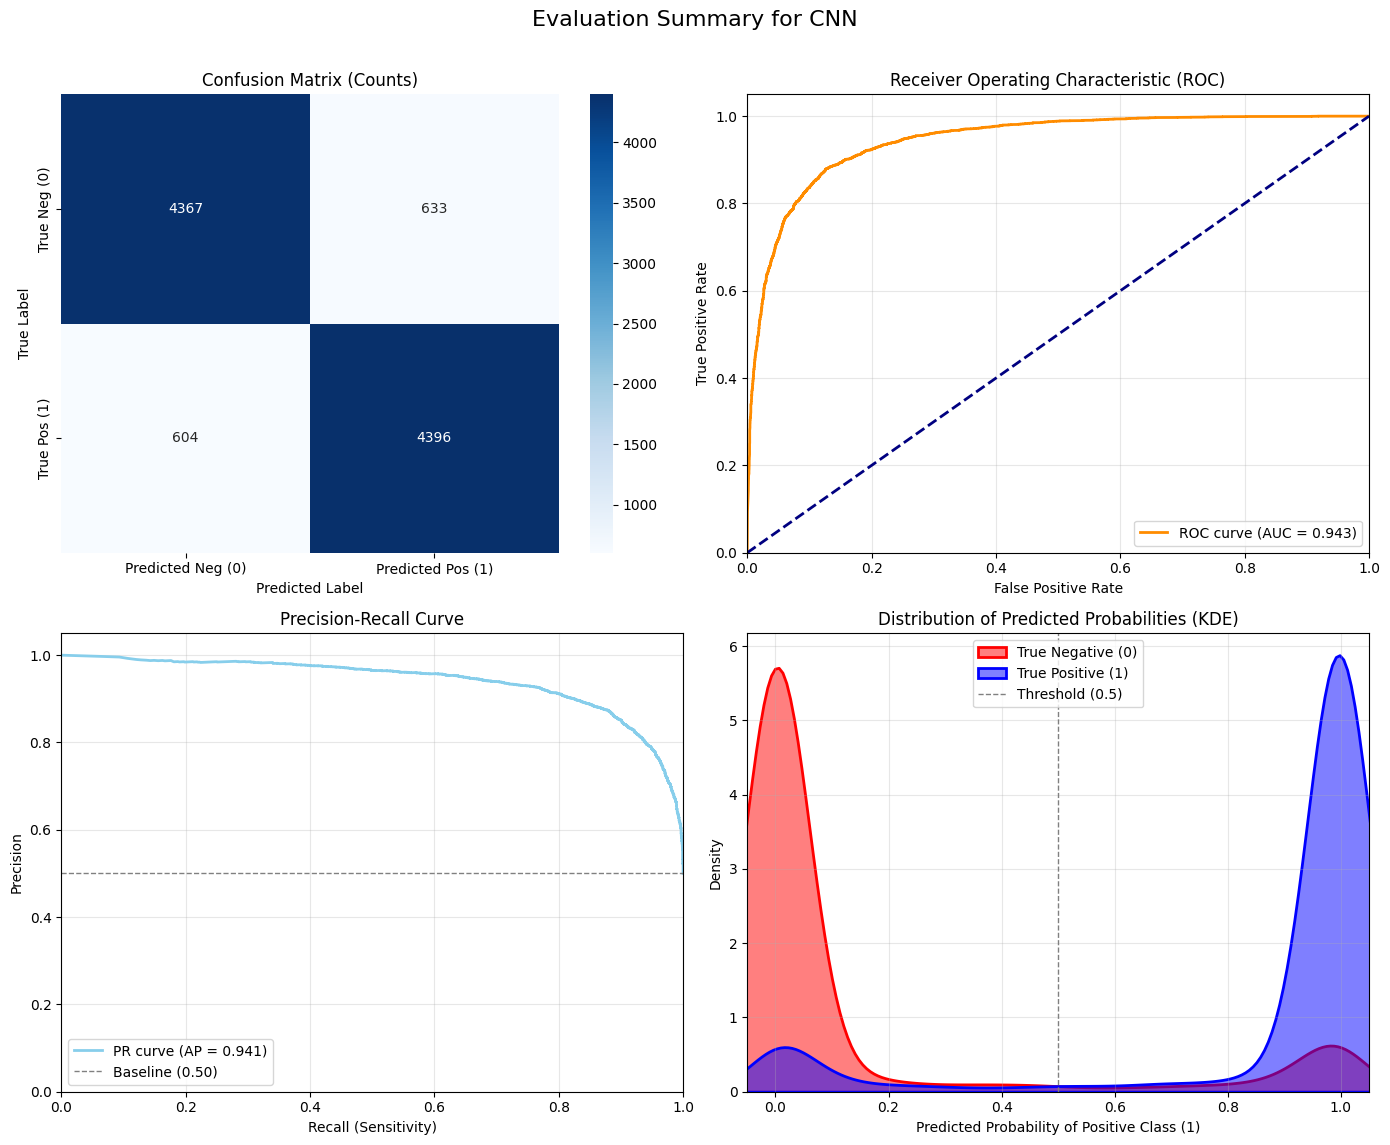

In [ ]:
cnn_results, cnn_fig = evaluate_sequential_model(
                            final_cnn_model,
                            X_test_pad, # Pass the padded sequences
                            y_test,
                            model_name="CNN",
                            batch_size=BATCH_SIZE_CNN # Use appropriate batch size
                        )
if cnn_fig:
     plt.show() # Display the plot

The CNN model achieved an accuracy of **87.63%** on the unseen test data, which indicates strong performance and good generalisation on unseen data.

Looking at the confusion matrix, the CNN model is able to identify a relatively large number of both and positive and negative reviews. The errors (FN, FP) are quite balanced and significantly smaller thatn the correct predictions, indicating good overall classification ability.

Based on the ROC curve, we have an AUC=0.943, suggesting that the model is capable of distinguishing between positive and negative classes.

Our precision-recall curve shows that the curve remains high even as recall increases, only dropping significantly at very high recall values. The average precision of 0.941 also affirms that the model maintians high precision when identifying a large proportion of true positive reviews.

The Kernel Density Estimate on the bottom right demonstrates how the model's predicted probabilites are distributed for samples that are truly negative versus those that are truly positive. There is a clear distinction between the two distributions, albeit some overlap and errors but they are relatively low density. In contrast, the narrow peaks indicate that the CNN model is generally confident in its predictions.